# Utils Troubleshooting
Let's test our formulae for the beer metrics (OG, FG, ABV, IBU, color) by comparing them to calculated values from Brewer's Friend.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from utils import *
pd.set_option('display.max_rows', 1000)

In [2]:
# DataFrame indices to give ~70,000 recipes from either recipe source
brewersfriend_indices = [330790, 403157]
brewtoad_indices = [258423, 330789]

In [3]:
# How close are we willing to consider our calculation of a field for it to be "ok"?
quality_cutoffs = {
    "og": 0.003,
    "fg": 0.003,
    "abv": 0.05,
    "ibu": 0.05, 
    "color": 0.05
}

In [4]:
def load_recipes(index_range):
    with pd.HDFStore("all_recipes.h5", "r") as store:
        where_clause = f"(index >= {index_range[0]}) & (index <= {index_range[1]})"
        core = store.select("/core", where=where_clause)
        ing = store.select("/ingredients", where=where_clause)
    df = core.join(ing)
    return df

In [5]:
def scale_ingreds(df):
    """Add columns for scaled ingredients to the DataFrame"""
    df["ferm_scaled"] = scale_ferm(df, "batch_size")
    df["hop_scaled"] = scale_hop(df, scale_volume_dry="batch_size", scale_volume_boil="boil_size") 
    return df

In [6]:
def calculate_metrics(df):
    """Add columns for the main beer measurements (IBU, SRM, ABV) to the DataFrame
    Use the functions defined in the Utils module."""
    df["pbg"] = gravity_wort(df, scale_volume="boil_size")
    df["og"] = gravity_wort(df, scale_volume="batch_size")  
    df["fg"] = gravity_final(df)
    df["abv"] = abv(df)
    df["color"] = srm(df, ferm_col="ferm_scaled")
    df["ibu"] = ibu(df, hop_col="hop_scaled")
    return df

In [7]:
def quality_measure(df, metric_calc, metric_validation, cutoff=0.05):
    """
    Indicate whether our calculated metric is close to a validation version of that metric (within the cutoff specified.)
    
    Parameters
    ===========
    metric_calc: Series 
        Our calculated metric (eg. "og")
    metric_validation: Series 
        The validation version of the metric we're using to test our calculation (eg. "src_og")
        
    Return
    ======
    Series of Booleans:
        Whether or not our metric is within in the cutoff of the metric
    """
    is_metric_within_cutoff = (abs(col_calc - col_validation)/col_validation) < cutoff
    return is_metric_within_cutoff

# Load Brewer's Friend recipes

In [80]:
bf = load_recipes(brewersfriend_indices) 

In [81]:
bf = scale_ingreds(bf)

In [82]:
bf.tail(5)

,batch_size,boil_size,boil_time,brewer,efficiency,name,origin,recipe_file,src_abv,src_color,...,yeast_amount,yeast_attenuation,yeast_flocculation,yeast_form,yeast_laboratory,yeast_name,yeast_product_id,yeast_type,ferm_scaled,hop_scaled
id,,,,,,,,,,,,,,,,,,,,,
403157,41.63953,48.264,60.0,grahamslam brewing,0.7,santa's schweddy balls,brewersfriend,recipes/brewersfriend/539881.xml,5.78,35.93,...,0.1,69.0,high,liquid,wyeast,california lager 2112,2112.0,lager,0.196080,0.000176
403157,41.63953,48.264,60.0,grahamslam brewing,0.7,santa's schweddy balls,brewersfriend,recipes/brewersfriend/539881.xml,5.78,35.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.032680,0.000050
403157,41.63953,48.264,60.0,grahamslam brewing,0.7,santa's schweddy balls,brewersfriend,recipes/brewersfriend/539881.xml,5.78,35.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021787,NaN
403157,41.63953,48.264,60.0,grahamslam brewing,0.7,santa's schweddy balls,brewersfriend,recipes/brewersfriend/539881.xml,5.78,35.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010893,NaN
403157,41.63953,48.264,60.0,grahamslam brewing,0.7,santa's schweddy balls,brewersfriend,recipes/brewersfriend/539881.xml,5.78,35.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021787,NaN


In [11]:
# Define sets of columns for troubleshooting later
recipe_basic_cols = ["name", "style_name", "boil_size", "batch_size"]
#   Calculated and test metrics
gravity_metric_cols = ["src_og", "src_fg", "src_abv", "og", "fg", "abv", "yeast_attenuation"]
hop_metric_cols = ["pbg", "src_ibu", "ibu"]
color_metric_cols = ["src_color", "color"]
#   Ingredient quantity columns
ferm_ingred_cols = ["efficiency", "ferm_name", "ferm_type", "ferm_amount", "ferm_yield", "ferm_color"]
hop_ingred_cols = ["hop_name", "hop_amount",  "hop_alpha", "hop_form", "hop_use"]
#   Assemble these into sets for troubleshooting metrics
gravity_cols = recipe_basic_cols + ferm_ingred_cols + gravity_metric_cols
ibu_cols = recipe_basic_cols + hop_ingred_cols + hop_metric_cols
color_cols = recipe_basic_cols + ferm_ingred_cols + color_metric_cols

# Investigation 1: OG and fermentable quantities

Let's define a basic formula for OG, and compare it to the Brewersfriend calculated OG for validation .

In [12]:
def og_test(
        df, 
        scale_volume_col="batch_size", 
        ferm_yield_col="ferm_yield", 
        efficiency_col="efficiency",
        adj_factor=1
    ):
    """
    *** Test version of the original gravity formula ***
    All the columns used in the calculation are parameters.
    
    Return the original gravity
    
    wort gravity = sum of (gravity contributions of each fermentable)
    Where, for a fermentable:
        gravity contribution (ºPlato) =
            mass * yield * moisture correction * efficiency / volume
    And:
        S.G. = 1 + 0.004 * ºPlato
        And moisture correction = 0.96

    Scaling the fermentable accounts for the ratio of mass and volume.

    Parameters
    ==========
    df: DataFrame
        A DataFrame containing, at minimum, the columns specified in 
        the other parameters.
    scale_volume: str, default "batch_size"
        The volume to use to scale the fermentable quantities.
    ferm_yield_col: str,
        The percentage of the fermentable's mass that it yields
        as fermentable extract.
    efficiency_col: str, 
        The percentage of the fermentable extract from the 
        fermentable that will dissolve in wort, contributing to OG.
    adj_factor: int,
        A scaling factor for fine-turning the calculation.

    Return
    ======
    Series representing original gravity for each recipe.
    """
    ferm_scaled = scale_ferm(df, scale_volume_col)

    # Ferm extract yields
    # Multiply by 100 to get from fraction to plato (which is percentage)
    fey = ferm_scaled * df[ferm_yield_col] * df[efficiency_col] * 100 * adj_factor
    return 1 + 0.004 * fey.groupby(fey.index).sum()

Let's create a visualization function to compare our calculated quantities to the validation ones, from Brewer's Friend

In [13]:
def plot_hexbin_gravity_dist(
    df, 
    col_calc, 
    col_validation,
    value_range=[1.0, 1.1]
):
    """ 
    Display a plot of a hexbin distribution between:
    
    and est_og """
    value_min = value_range[0]
    value_max = value_range[1]
    
    fig = plt.figure(figsize=[16,12])
    ax = fig.add_subplot(111)
    
    colormap = ax.hexbin(
        df[col_calc].values, 
        df[col_validation].values, 
        extent=[value_min, value_max, value_min, value_max],
        mincnt=10, 
        norm=LogNorm()
    )
    # Guidelines to catch relationships within certain factors
    guideline_ratios = [2, 1, 0.5]
    for ratio in guideline_ratios:
        ax.plot([value_min, 1 + 1], [value_min, 1 + ratio * 1], lw=3, label=f"1:{ratio}")
    
    ax.set_title(f"Comparison of distributions:\n{col_calc} vs {col_validation}")
    ax.set_xlim([value_min, value_max])
    ax.set_ylim([value_min, value_max])
    ax.set_xlabel(col_calc)
    ax.set_ylabel(col_validation)
    ax.legend()
    fig.colorbar(colormap)
    plt.show()

Now we're ready to test our formula for OG.
Let's calculate OG and plot its distribution compared to BrewersFriend.

In [83]:
bf["og"] = og_test(bf, scale_volume_col="batch_size", ferm_yield_col="ferm_yield", efficiency_col="efficiency")

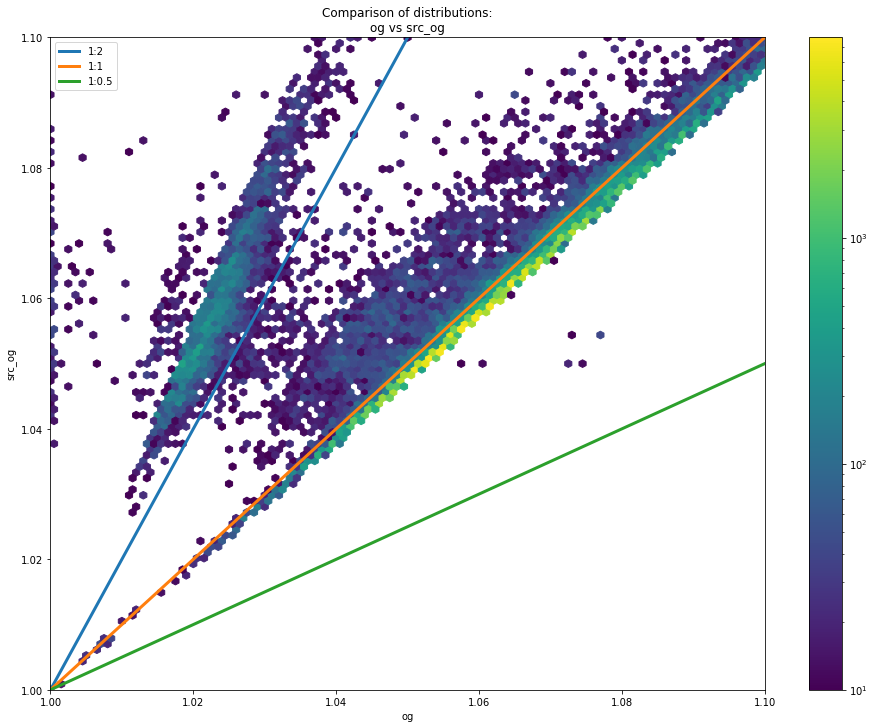

In [85]:
plot_hexbin_gravity_dist(bf, "og", "src_og")

## OG Correction #1: Moisture

The biggest difference in the Brewer's Friend OGs and ours is that our highest density bins fall *just under the 1:1 guide line*.
This means that we're systematically over-estimating OGs by a small factor. What could fix for this?


Adjusting for moisture! 


According to the American maltster Briess, [malt is typically 3-6% moisture](http://blog.brewingwithbriess.com/understanding-a-malt-analysis/). Brewer's Friend [suggests applying a 4% correction](https://www.brewersfriend.com/2012/11/30/making-sense-of-efficiency-definitions/) to the weight of grain to account for moisture.

Let's calculate a version of OG with a 4% correction applied and call it "V1".

In [86]:
bf["og_v1"] = og_test(bf, scale_volume_col="batch_size", ferm_yield_col="ferm_yield", efficiency_col="efficiency", adj_factor=0.96)

How does this OG compare to our previous one?

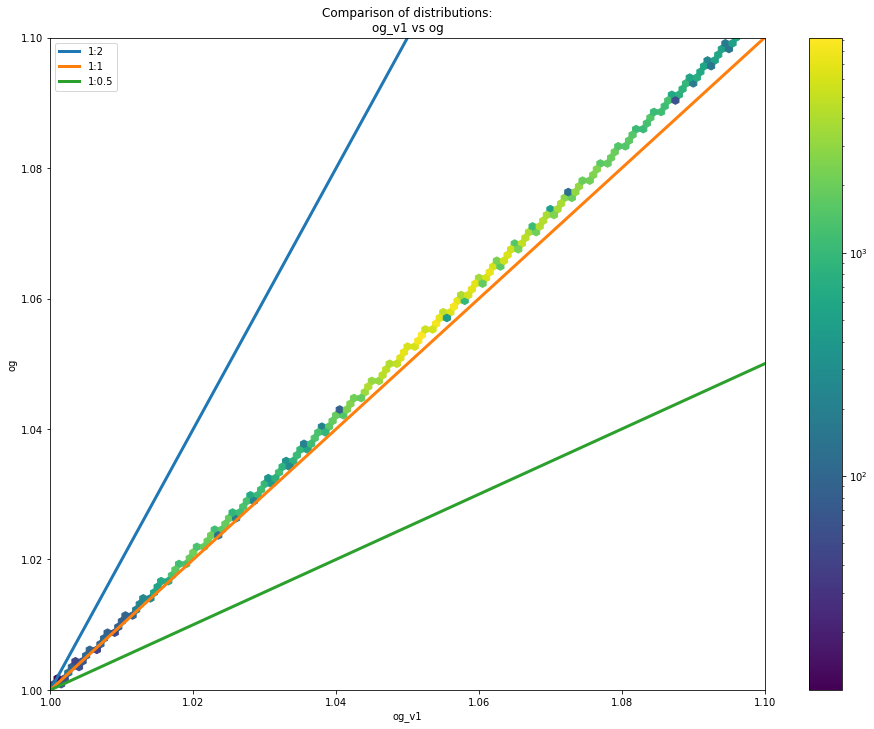

In [87]:
plot_hexbin_gravity_dist(bf, "og_v1", "og")

How does this OG compare to Brewer's Friend?

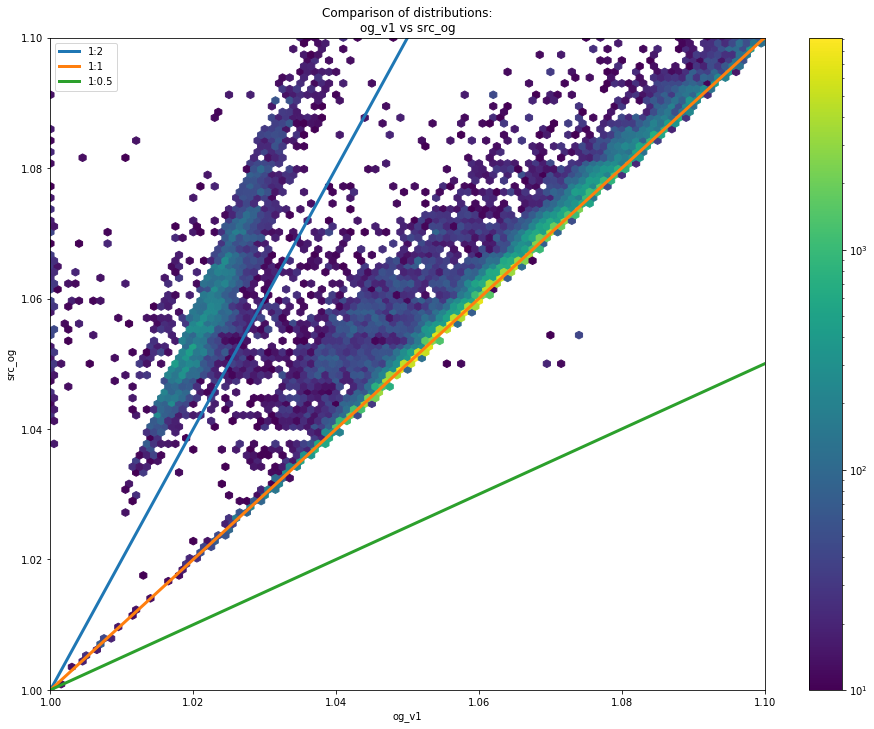

In [88]:
plot_hexbin_gravity_dist(bf, "og_v1", "src_og")

Much better!

**Correction 1: multiply gravity by 0.96% to correct for moisture**

## OG Correction #2: Low values of efficiency 

The next biggest discrepancy between our OG and Brewer's Friend are recipes *above the 1:2 guideline*. 

These are recipes where we're drammtically under-estimating OG, by a factor of more than 2. What do these have in common? (Note that there's a distinct group where our OG is very close to 0, near the y-axis. Let's ignore those for now.)

In [89]:
mask_low_og = ((bf["src_og"]-1) > ((bf["og_v1"]-1) * 2)) & (bf["og_v1"] > 1.010)

In [90]:
bf[mask_low_og][recipe_basic_cols + ferm_ingred_cols].dropna().head(25)

,name,style_name,boil_size,batch_size,efficiency,ferm_name,ferm_type,ferm_amount,ferm_yield,ferm_color
id,,,,,,,,,,
330793,pete & annas wedding ale,california common beer,12.000000,24.000000,0.35,dry malt extract - light,dry extract,2.000000,0.9130,4.0
330793,pete & annas wedding ale,california common beer,12.000000,24.000000,0.35,dry malt extract - extra light,dry extract,1.000000,0.9130,2.5
330793,pete & annas wedding ale,california common beer,12.000000,24.000000,0.35,crystal 70l,grain,0.400000,0.7391,70.0
330796,mid-mountain imperial ipa,imperial ipa,49.210353,37.854118,0.45,liquid malt extract - light,extract,5.443108,0.7609,4.0
330796,mid-mountain imperial ipa,imperial ipa,49.210353,37.854118,0.45,dry malt extract - light,dry extract,4.082331,0.9130,4.0
330796,mid-mountain imperial ipa,imperial ipa,49.210353,37.854118,0.45,caramel / crystal 15l,grain,0.907185,0.7609,15.0
330796,mid-mountain imperial ipa,imperial ipa,49.210353,37.854118,0.45,caramel / crystal 40l,grain,0.907185,0.7391,40.0
330796,mid-mountain imperial ipa,imperial ipa,49.210353,37.854118,0.45,flaked rye,adjunct,0.453592,0.7826,2.8
330800,frankenbrew,american pale ale,9.463529,14.952377,0.35,liquid malt extract - amber,extract,2.721554,0.7609,10.0


They appear to have very low efficiencies! What's the distribution of efficiencies like for these recipes?

In [91]:
bf[mask_low_og]["efficiency"].value_counts().head(10)

0.35    33453
0.25     1659
0.30      485
0.40      435
0.75      184
0.45      124
0.20      121
0.15       87
0.70       44
0.33       42
Name: efficiency, dtype: int64

Almost all of these recipes have efficiency > 0.5. 

This seems unphysical! Even very beginner homebrewing setups get above 50% efficiency. What happens when we correct efficiency by replacing values below 0.50 with the mean?

In [92]:
def split_series_on_range(series, min_value, max_value):
    inside_mask = series.between(min_value, max_value)
    inside = series[inside_mask]
    outside = series[~inside_mask]
    return inside, outside

In [93]:
def replace_with_mean(series, acceptable_min=0.5, acceptable_max=1.0):
    """ Replace unacceptable quantities in a series with the mean acceptable quantity. """
    good, bad = split_series_on_range(series, acceptable_min, acceptable_max)
    mean_good = good.groupby(good.index).first().mean()
    fixed_series = good.append(pd.Series(index=bad.index, data=mean_good))
    return fixed_series.sort_index()

In [94]:
bf["eff_adj_mean"]  = replace_with_mean(bf["efficiency"])

What effect does correcting these efficiencies have on OG?

Let's calculate another version of OG from these efficiences. This one is version 2.

In [95]:
bf["og_v2"] = og_test(bf, scale_volume_col="batch_size", ferm_yield_col="ferm_yield", efficiency_col="eff_adj_mean", adj_factor=0.96)

How does this help for the problematic recipes we identified?

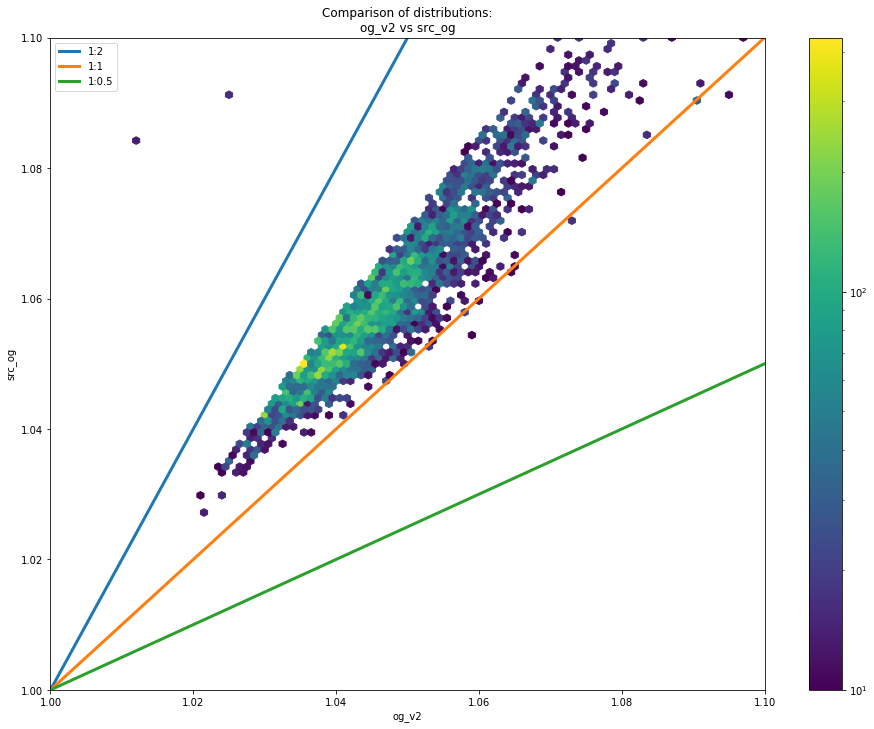

In [96]:
plot_hexbin_gravity_dist(bf[mask_low_og], "og_v2", "src_og")

How much closer does this bring us to Brewer's Friend overall?

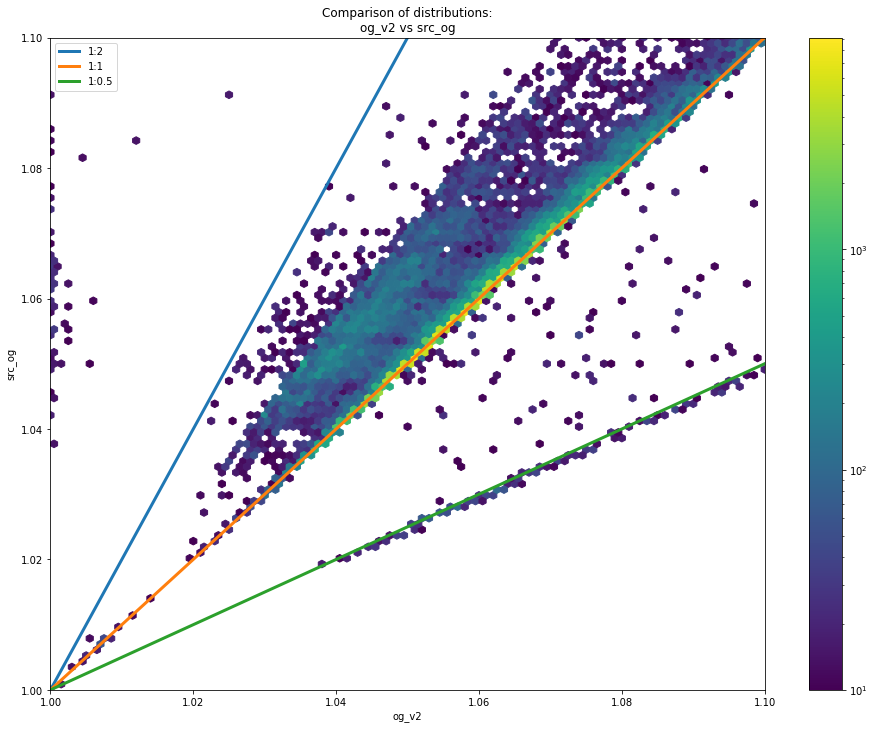

In [97]:
plot_hexbin_gravity_dist(bf, "og_v2", "src_og")

This is better, but it's not perfect. What else could be going on?

We'll keep this correction, and keep digging:

**Correction 2: replace efficiencies below 0.50 by the mean efficiency outside of that range**

# OG Correction #3: Efficiency for non-grain fermentables

What else is in common with these recipes?

In [98]:
bf[mask_low_og][recipe_basic_cols + ferm_ingred_cols].dropna().head(15)

,name,style_name,boil_size,batch_size,efficiency,ferm_name,ferm_type,ferm_amount,ferm_yield,ferm_color
id,,,,,,,,,,
330793,pete & annas wedding ale,california common beer,12.000000,24.000000,0.35,dry malt extract - light,dry extract,2.000000,0.9130,4.0
330793,pete & annas wedding ale,california common beer,12.000000,24.000000,0.35,dry malt extract - extra light,dry extract,1.000000,0.9130,2.5
330793,pete & annas wedding ale,california common beer,12.000000,24.000000,0.35,crystal 70l,grain,0.400000,0.7391,70.0
330796,mid-mountain imperial ipa,imperial ipa,49.210353,37.854118,0.45,liquid malt extract - light,extract,5.443108,0.7609,4.0
330796,mid-mountain imperial ipa,imperial ipa,49.210353,37.854118,0.45,dry malt extract - light,dry extract,4.082331,0.9130,4.0
330796,mid-mountain imperial ipa,imperial ipa,49.210353,37.854118,0.45,caramel / crystal 15l,grain,0.907185,0.7609,15.0
330796,mid-mountain imperial ipa,imperial ipa,49.210353,37.854118,0.45,caramel / crystal 40l,grain,0.907185,0.7391,40.0
330796,mid-mountain imperial ipa,imperial ipa,49.210353,37.854118,0.45,flaked rye,adjunct,0.453592,0.7826,2.8
330800,frankenbrew,american pale ale,9.463529,14.952377,0.35,liquid malt extract - amber,extract,2.721554,0.7609,10.0


A lot of these recipes are made with sugar and malt extract!

Are these fermentable types more common than in the dataset as a whole?

In [99]:
extract_mask = bf["ferm_type"].isin(["sugar", "dry extract", "extract"])

In [100]:
bf[extract_mask & mask_low_og]["ferm_type"].value_counts(normalize=True) / bf[extract_mask]["ferm_type"].value_counts(normalize=True) 

dry extract    1.372684
extract        1.624117
sugar          0.476104
Name: ferm_type, dtype: float64

Yes they definitely are.

In [101]:
bf["ferm_type"].value_counts(normalize=True)

grain          0.805611
adjunct        0.074889
sugar          0.057451
dry extract    0.034312
extract        0.027737
Name: ferm_type, dtype: float64

In [102]:
bf[mask_low_og]["ferm_type"].value_counts(normalize=True)

grain          0.460842
dry extract    0.197074
extract        0.188491
sugar          0.114451
adjunct        0.039141
Name: ferm_type, dtype: float64

Do these fermentable types have the same names in the Brewtoad dataset?

In [103]:
bt = load_recipes(brewtoad_indices) 
bt["ferm_type"].value_counts()

caramel/crystal malt    58761
grain                   54451
adjunct                 48493
base malt               45292
kilned malt             35243
roasted malt            28558
sugar                   15266
liquid extract          15015
dry extract             14435
mash                       25
Name: ferm_type, dtype: int64

They're similar but not quite the same. So here's the list of ferm_types that correspond to sugars or extracts:

In [104]:
extract_types = ["sugar", "dry extract", "liquid extract", "extract"]

Let's inspect some examples to sanity check.

In [105]:
bf[bf["ferm_type"].isin(extract_types)].groupby(["ferm_type", "ferm_name"])["batch_size"].count().head(25)

ferm_type    ferm_name                              
dry extract  dry malt extract - amber                   1189
             dry malt extract - dark                     708
             dry malt extract - extra light             1228
             dry malt extract - light                   4271
             dry malt extract - munich                   168
             dry malt extract - pilsen                  1223
             dry malt extract - wheat                   1204
             rice syrup solids                           107
extract      liquid malt extract - amber                1144
             liquid malt extract - dark                  653
             liquid malt extract - extra light           546
             liquid malt extract - light                3191
             liquid malt extract - maris otter           231
             liquid malt extract - munich                481
             liquid malt extract - pilsen               1072
             liquid malt extract

In [106]:
check_result = bt[bt["ferm_type"].isin(extract_types)].groupby(["ferm_type", "ferm_name"])["batch_size"].count()
check_result[check_result > 200].head(25)

ferm_type       ferm_name                     
dry extract     amber dme                          341
                bavarian wheat dme                 829
                dark dry malt extract              222
                dry malt extract - amber           409
                dry malt extract - dark            227
                dry malt extract - extra light     608
                dry malt extract - light          1813
                dry malt extract - pilsen          757
                dry malt extract - wheat           550
                golden light dme                  3411
                light dry extract                  339
                light dry malt extract             489
                pilsen light dme                  1328
                plain extra light dme              218
                plain light dme                    359
                sparkling amber dme                636
                wheat dme                          290
liquid extract  br

Looks good. Let's adjust efficiency for thest fermentable types, and calculate a new OG from it.

Since they're added directly to the kettle, the efficiency should be 1.

In [112]:
def adjust_efficiency(df, col_efficiency, ferm_types_extract, new_efficiency=1):
    """
    Return a Series of adjusted efficiencies based on the ferm_type / name.
    """
    extract_mask = df["ferm_type"].isin(ferm_types_extract)
    extract_inds = np.where(extract_mask)[0]
    other_mask = ~extract_mask
    other_inds = np.where(other_mask)[0]

    extract_eff = pd.Series(new_efficiency * np.ones(len(extract_inds)), index=extract_inds)
    other_eff = df.loc[other_mask, "efficiency"]
    other_eff.index = other_inds

    all_ferms = extract_eff.append(other_eff).sort_index()
    all_ferms.index = df.index
    return all_ferms

In [108]:
bf["eff_adj_mean_type"] = adjust_efficiency(bf, col_efficiency="eff_adj_mean", ferm_types_extract=extract_types, new_efficiency=1)

This is our third OG calculation.

In [109]:
bf["og_v3"] = og_test(bf, scale_volume_col="batch_size", ferm_yield_col="ferm_yield", efficiency_col="eff_adj_mean_type", adj_factor=0.96)

How much closer to Brewer's Friend does this get us for the problematic recipes?

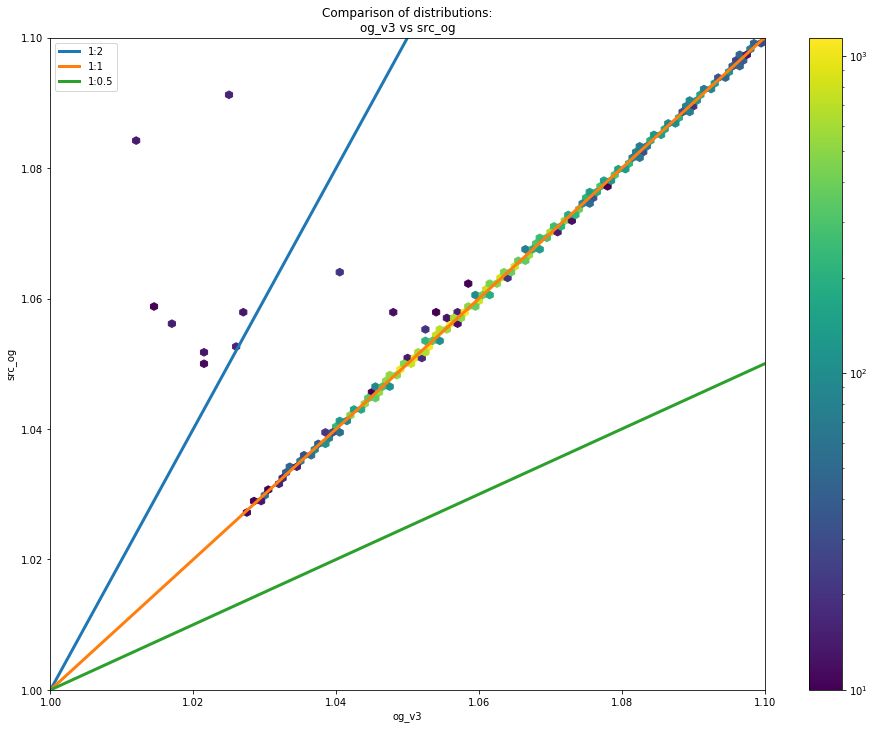

In [110]:
plot_hexbin_gravity_dist(bf[mask_low_og], "og_v3", "src_og")

Way better! Wow! What does the distribution look like overall now?

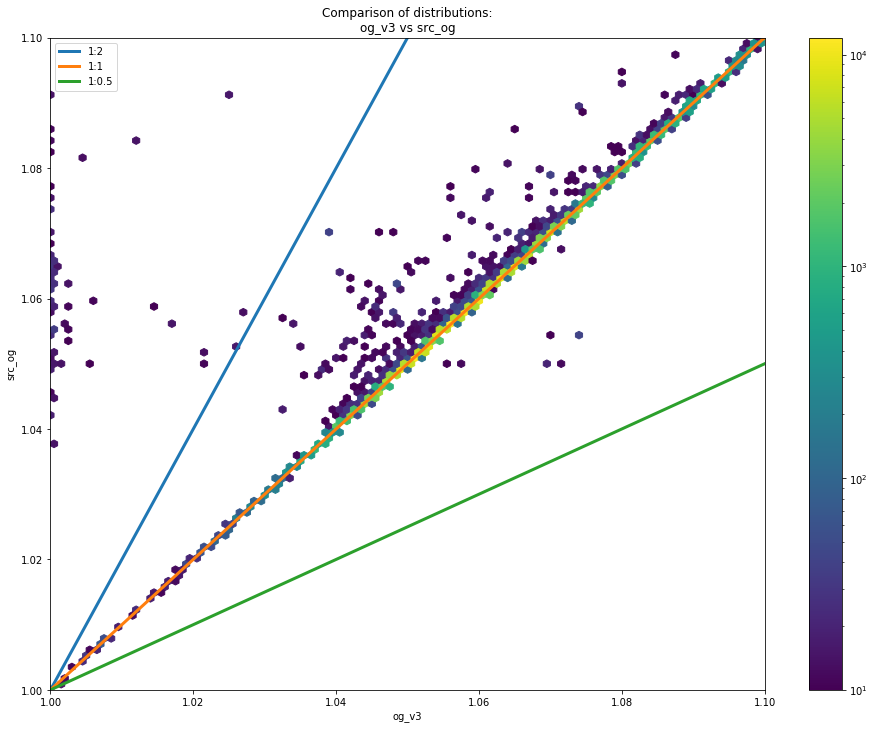

In [111]:
plot_hexbin_gravity_dist(bf, "og_v3", "src_og")

This is an important correction!

**Correction 3: replace efficiencies for ferm_types corresponding to extracts and sugars with 1**

# OG Correction #4: Fill in fermentable yields that are 0

The last remaining obvious discrepancy between our OG and Brewer's Friend are the recipes near the y-axis.

These are recipes where the Brewer's friend OG is very very low. What do they have in common?

In [113]:
mask_bf_low_og = bf["src_og"] < 1.005

In [114]:
bf[mask_bf_low_og][recipe_basic_cols + ferm_ingred_cols].dropna().head(30)

,name,style_name,boil_size,batch_size,efficiency,ferm_name,ferm_type,ferm_amount,ferm_yield,ferm_color
id,,,,,,,,,,
331547,blood orange and bergamot,american light lager,180.000000,165.000000,0.80,flaked barley,adjunct,1.000000,0.6957,2.2
331955,hefeweizen,dunkelweizen,18.000000,18.000000,0.75,cane sugar,sugar,0.100000,1.0000,0.0
332552,awesome recipe,american amber ale,22.712471,56.781177,0.35,flaked barley,adjunct,0.453592,0.6957,2.2
333590,frankenstout,russian imperial stout,15.141647,22.712471,0.35,chocolate,grain,1.133981,0.6522,340.0
334309,chai tea coconut stout,oatmeal stout,3.785412,9.463529,0.75,sticky wicket oat meal stout hme,grain,17.599384,0.0000,0.0
336148,cider 3,common cider,9.463529,9.463529,0.00,dry malt extract - amber,dry extract,0.045359,0.9130,10.0
336642,nut brown ale partial mash,american brown ale,18.927059,18.927059,0.75,simpson's chocolate,grain,0.113398,0.2028,400.0
336642,nut brown ale partial mash,american brown ale,18.927059,18.927059,0.75,belgian special b,grain,0.113398,0.0000,350.0
336642,nut brown ale partial mash,american brown ale,18.927059,18.927059,0.75,belgian biscuit malt,grain,0.113398,0.7826,23.0


Lots of these recipes have low ferm_yields! Some are even 0.

What's the distribution of ferm_yields like for these recipes?

In [115]:
bf[mask_bf_low_og]["ferm_yield"].value_counts(normalize=True).head(10)

0.0000    0.191919
0.6957    0.131313
0.0217    0.111111
0.7609    0.101010
0.9130    0.060606
0.7391    0.060606
0.7174    0.050505
0.8043    0.030303
0.0225    0.030303
0.9783    0.030303
Name: ferm_yield, dtype: float64

What about in total for our dataset?

In [116]:
bf["ferm_yield"].value_counts(normalize=True).head(10)

0.8043    0.197940
0.7174    0.153336
0.7391    0.152123
0.8261    0.123445
0.7609    0.098440
0.9130    0.040686
0.6957    0.036092
0.7826    0.033768
0.6304    0.029820
1.0000    0.022110
Name: ferm_yield, dtype: float64

It looks like ferm_yields from 0 to 0.0225 are way more common in these problematic recipes than overall.

Let's fix them by setting them to the mean for the ferm_type. An important exception is rice hulls, which we need to make sure have a ferm_yield = 0.

In [120]:
ferm_yield_cutoff = 0.03

In [124]:
good_ferm_yield_mask = bf["ferm_yield"] > ferm_yield_cutoff
bad_ferm_yield_mask = bf["ferm_yield"] <= ferm_yield_cutoff
non_rice_hulls_mask = bf["ferm_name"] != "rice hulls"

In [123]:
ferm_yield_mean = bf[good_ferm_yield_mask].groupby("ferm_type")["ferm_yield"].mean()
ferm_yield_mean

ferm_type
adjunct        0.742587
dry extract    0.914883
extract        0.764420
grain          0.758901
sugar          0.915080
Name: ferm_yield, dtype: float64

In [128]:
ferm_yield_ind_to_replace = bf[bad_ferm_yield_mask & non_rice_hulls_mask].index
bf["ferm_yield_adj"] = bf["ferm_yield"]
bf.loc[ferm_yield_ind_to_replace, "ferm_yield_adj"] = bf.loc[ferm_yield_ind_to_replace, "ferm_type"].map(ferm_yield_mean)

Let's sanity check the replacements worked.

In [131]:
bf[~bf["ferm_name"].isna()].loc[ferm_yield_ind_to_replace][["ferm_name", "ferm_yield", "ferm_yield_adj"]].head(10)

,ferm_name,ferm_yield,ferm_yield_adj
id,,,
330883,barley (flaked),0.0,0.758901
330883,munich (light),0.0,0.758901
330883,crystal 10l,0.0,0.758901
330883,malt - amber,0.0,0.758901
330883,barley (flaked),0.0,0.758901
330883,munich (light),0.0,0.758901
330883,crystal 10l,0.0,0.758901
330883,malt - amber,0.0,0.758901
330883,barley (flaked),0.0,0.758901


Finally, what the effect on OG?

This is our fourth OG calculation.

In [132]:
bf["og_v4"] = og_test(bf, scale_volume_col="batch_size", ferm_yield_col="ferm_yield_adj", efficiency_col="eff_adj_mean_type", adj_factor=0.96)

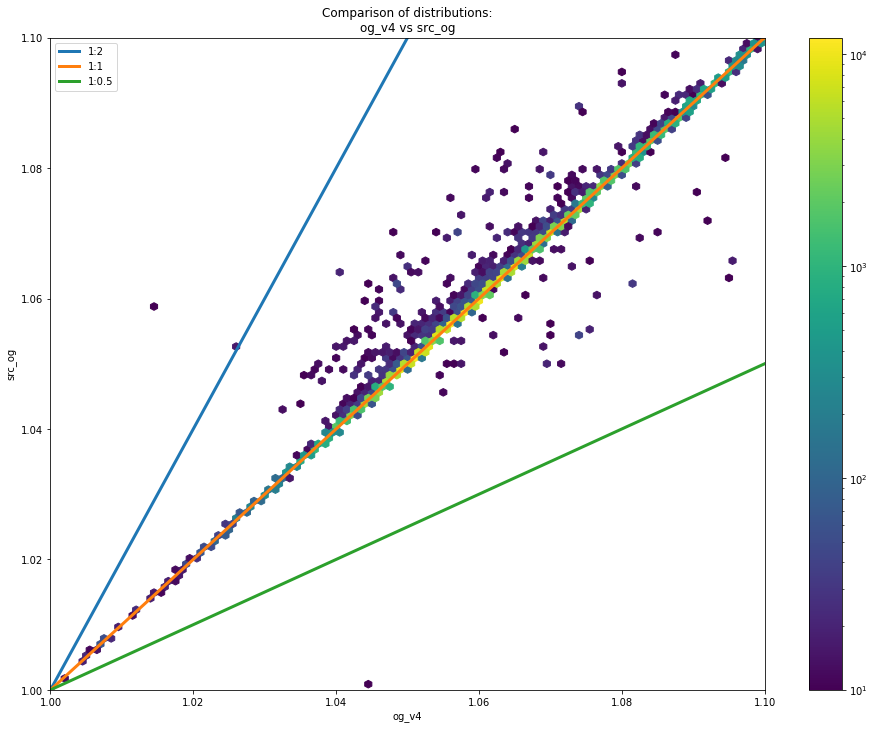

In [133]:
plot_hexbin_gravity_dist(bf, "og_v4", "src_og")

Much better!

**Correction 4: replace low ferm_yields for fermentables other than rice hulls with the mean for the ferm_type**

### Summary of OG corrections
* Correction 1: multiply gravity by 0.96% to correct for moisture
* Correction 2: replace efficiencies below 0.50 by the mean efficiency outside of that range
* Correction 3: replace efficiencies for ferm_types corresponding to extracts and sugars with 1
* Correction 4: replace ferm_yields below 0.03 for fermentables other than rice hulls with the mean outside of that range for the ferm_type


# Investigation 1.5: ABV and FG

# Investigation 2: IBU and hop quantities

In [44]:
def plot_hexbin_ibu_dist(df, col_test):
    """ Display a plot of a hexbin distribution betwen the test column and est_og """
    value_min = 0
    value_max = 120
    fig = plt.figure(figsize=[16,12])
    ax = fig.add_subplot(111)
    ax.set_title(f"{col_test} vs src_ibu")
    colormap = ax.hexbin(df[col_test].values, df["src_ibu"].values, extent=[value_min, value_max, value_min, value_max], mincnt=10, norm=LogNorm())
    ax.plot([value_min, value_max], [value_min, 2*value_max], color="tomato", lw=3)
    ax.plot([value_min, value_max], [value_min, value_max], color="tomato", lw=3)
    ax.plot([value_min, value_max], [value_min, 0.5*value_max], color="tomato", lw=3)
    ax.set_xlim([value_min, value_max])
    ax.set_ylim([value_min, value_max])
    ax.set_xlabel(col_test)
    ax.set_ylabel("src_ibu")
    fig.colorbar(colormap)
    plt.show()

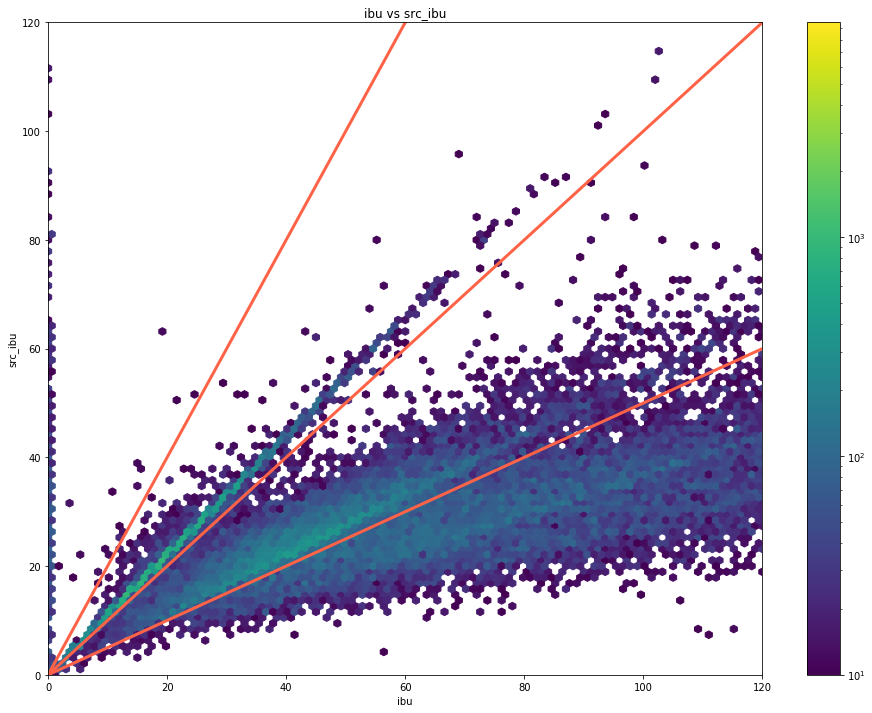

In [45]:
plot_hexbin_ibu_dist(df, "ibu")

# Investigation 3: SRM and fermentable colors and quantities

In [54]:
def plot_hexbin_srm_dist(df, col_test):
    """ Display a plot of a hexbin distribution betwen the test column and est_og """
    value_min = 0
    value_max = 60
    fig = plt.figure(figsize=[16,12])
    ax = fig.add_subplot(111)
    ax.set_title(f"{col_test} vs src_color")
    colormap = ax.hexbin(df[col_test].values, df["src_color"].values, extent=[value_min, value_max, value_min, value_max], mincnt=10, norm=LogNorm())
    ax.plot([value_min, value_max], [value_min, 2*value_max], color="tomato", lw=3)
    ax.plot([value_min, value_max], [value_min, value_max], color="tomato", lw=3)
    ax.plot([value_min, value_max], [value_min, 0.5*value_max], color="tomato", lw=3)
    ax.set_xlim([value_min, value_max])
    ax.set_ylim([value_min, value_max])
    ax.set_xlabel(col_test)
    ax.set_ylabel("src_color")
    fig.colorbar(colormap)
    plt.show()

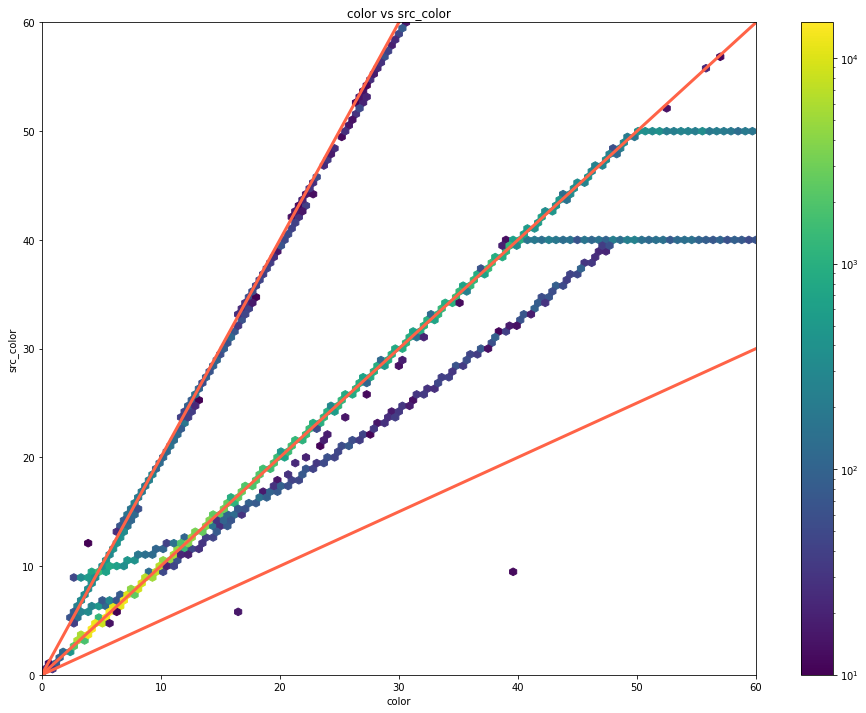

In [55]:
plot_hexbin_srm_dist(df, "color")